# Hypothesis Testing in Healthcare: Drug Safety

## The Context

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset provided contained five adverse effects, demographic data, vital signs, etc. Your organization is primarily interested in the drug's adverse reactions. It wants to know if the adverse reactions, if any, are of significant proportions. It has asked you to explore and answer some questions from the data.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda).

In [109]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest
import pingouin

# Load the dataset
drug_safety = pd.read_csv("drug_safety.csv")

In [110]:
drug_safety.head()

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0


## Question 1

**Question 1**:  Is there a statistically significant **difference** in the **proportion** of adverse effects between the **two groups** in `trx`, providing insight into whether the pharmaceutical drug created statistically significant side effects?

### Two-sample proportion z-test

**Explanation:** The two-sample proportion z-test is chosen when comparing the proportions of two independent groups to determine if they are significantly different from each other. 

### Hypothesises

- The Null Hypothesis (Ho): The proportion of `adverse_effect` for Drug and Placebo groups is **the same.**

- The Alternative Hypothesis (Ha): The proportion of `adverse_effect` for Drug and Placebo groups is **significantly different.**

In [111]:
# Count the adverse_effects column values for each trx group
trx_count = drug_safety.groupby('trx')['adverse_effects'].value_counts()

# Create an array of the "Yes" counts for each group
n_trx = np.array([trx_count['Drug','Yes'], trx_count['Placebo','Yes']])
# Create an array of the total number of rows in each group
n_row = np.array([trx_count['Drug'].sum(), trx_count['Placebo'].sum()])

# Perform a two-sided z-test on the two proportions
z_score_1, p_value_1 = proportions_ztest(
                                        count = n_trx,
                                        nobs = n_row,
                                        alternative = 'two-sided')
# Store the p-value
two_sample_p_value = p_value_1
print('two_sample_p_value:', two_sample_p_value)

two_sample_p_value: 0.9639333330262475


## Question 2

**Question 2:** Is there an association between adverse effects and the `trx` groups, providing insight into whether `trx` influences the number of effects? 

### Chi-square test of independence

**Explanation:** The Chi-square test of independence is chosen to determine whether there is a significant association between two categories vairiables.

### Hypothesises

- Ho: The trx groups are **independent** of adverse effects
- Ha: The trx groups are **not independent** of adverse effects

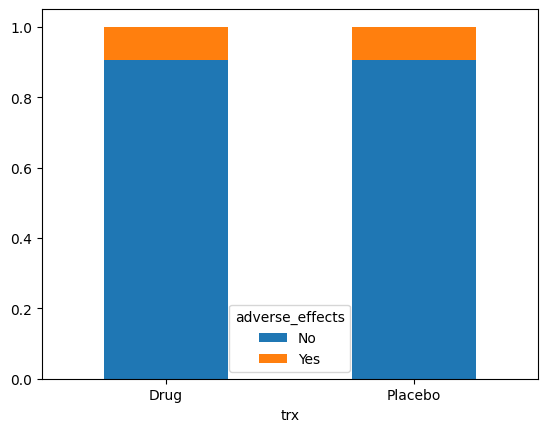

In [112]:
# Visualize chi2 of independence stacked bar chart
props = drug_safety.groupby('trx')['adverse_effects'].value_counts(normalize=True)
wide_props = props.unstack()

wide_props.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.show()

In [113]:
# Determine if num_effects and trx are independent
# chi-square test of independence
expected, observed, stats = pingouin.chi2_independence(
                                                        data = drug_safety,
                                                        x = 'num_effects',
                                                        y = 'trx',
                                                        correction = False)
print(stats)

# Extract the p-value
num_effects_p_value = stats[stats['test']=='pearson']['pval'].values[0]
print('\n num_effects_p_valueL:', num_effects_p_value)

                 test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  1.799644  3.0  0.615012  0.010572  0.176275
1        cressie-read  0.666667  1.836006  3.0  0.607131  0.010678  0.179153
2      log-likelihood  0.000000  1.922495  3.0  0.588648  0.010926  0.186033
3       freeman-tukey -0.500000  2.001752  3.0  0.572043  0.011149  0.192379
4  mod-log-likelihood -1.000000  2.096158  3.0  0.552690  0.011409  0.199984
5              neyman -2.000000  2.344303  3.0  0.504087  0.012066  0.220189

 num_effects_p_valueL: 0.6150123339426765


## Question 3

**Question 3:** Is age normally distributed?

**Explanation:** To determine what test to use to confirm whether age differs significantly between the trx groups, it is required to check if age is normally distributed in the trx groups.

### Normality Testing

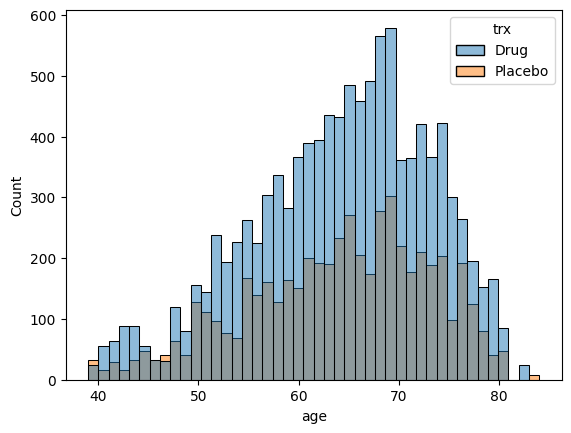

In [114]:
# Create a histogram of age feature
sns.histplot(data=drug_safety, x='age', hue='trx')
plt.show()

In [115]:
# Confirm the histogram's output by conducting a normality test 
pingouin.normality(drug_safety, dv='age', group='trx', method='shapiro', alpha=0.05)

,W,pval,normal
trx,,,
Drug,0.976785,2.189152e-38,False
Placebo,0.975595,2.224950e-29,False


## Question 4

**Question 4:** Is there significant difference between the ages of both groups?

Explanation: To ensure `age` wasn't a confounder, conduct a **Mann-Whitney test** to determine if `age` differed significantly between the `trx` groups.

### Mann Whitey U Test

Age Range here is **a ordinal variable**, so **Mann-Whitney test** is prefered instead of Chi2 of independence test (prefered when age is a nominal variable).

### Hypothesises

- Ho: There is **no significant difference** between the ages of `trx` groups
- Ha: There is **significant difference** between the ages of `trx` groups

In [116]:
# Mann Whitney U test

# Calculate mean and count
print(drug_safety.groupby('trx')['age'].agg({'mean','count'}))

# Set seed
np.random.seed(131)

# Select the age of the Drug group
sample_drug = drug_safety[drug_safety['trx']=='Drug']['age']
# Select the age of the Placebo group
sample_placebo = drug_safety[drug_safety['trx']=='Placebo']['age']

# Conduct a two-sided Mann-Whitney U testt
mwu_test = pingouin.mwu(
                x= sample_drug,
                y= sample_placebo,
                )
print('\n')
print(mwu_test)
# Extract the p-value
age_group_effects_p_value = mwu_test['p-val']

         count       mean
trx                      
Drug     10727  64.190268
Placebo   5376  63.972470


          U-val alternative     p-val      RBC      CLES
MWU  29149339.5   two-sided  0.256963 -0.01093  0.505465
